# Start

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('int20h-ds-test-dataset.csv') #load notebook

In [2]:
df_sorted = df[[
    'userid',
    'user_state',
    'event_name',
    'event_attributes',
    'event_created_date',
    'event_platform',
    'device_manufacture',
    # 'device_model'
]].sort_values(['userid','event_created_date'])

In [3]:
#меняю event_platform из outofband на соответствующий ему тим

for user_ID_idx in set(df_sorted.userid):
    df_sorted_slice = df_sorted[df_sorted.userid == user_ID_idx]
    event_platform_slice = set(df_sorted_slice.event_platform)
    if 'outofband' in event_platform_slice and len(event_platform_slice) != 1:
        event_platform_slice.remove("outofband")
        true_device = list(event_platform_slice)[0]
        for index in df_sorted_slice.index:
            df_sorted.at[index, 'event_platform'] = true_device

In [4]:
#меняю device_manufacture из outofband на соответствующий ему тим

for user_ID_idx in set(df_sorted.userid):
    df_sorted_slice = df_sorted[df_sorted.userid == user_ID_idx]
    device_manufacture_slice = set(df_sorted_slice.device_manufacture)
    if np.nan in device_manufacture_slice and len(device_manufacture_slice) != 1:
        device_manufacture_slice.remove(np.nan)
        true_device = list(device_manufacture_slice)[0]
        for index in df_sorted_slice.index:
            df_sorted.at[index, 'device_manufacture'] = true_device
            
df_sorted=df_sorted.fillna(0)

In [5]:
len(set(df_sorted.userid.tolist()))  # uniqie userID

3540

In [6]:
# удаляю Chat Conversation Opened потому-что эти данные есть в событие Chat Conversation Started

df_sorted = df_sorted[df_sorted.event_name != 'Chat Conversation Opened']

In [7]:
import ast
from tqdm import tqdm

#переганяю все event_attributes в формат словаря

for i in df_sorted.index:
    if type(df_sorted.event_attributes.loc[i]) != dict:
        df_sorted.at[i, 'event_attributes'] = ast.literal_eval(
            df_sorted.event_attributes.loc[i])

In [8]:
delete_index = []

# делаю жоский дата саенс, удаляю все записи по каждому пользователю после события
# 'Subscription Premium Cancel'- потому-что после этого события данные мне не нужны, 
# важно что пользователь отменил подписку и надо понять почему. Данные после отмены мусорят датасет
# Дополнительн я проверил, что после события 'Subscription Premium Cancel' больше не было покупки подписки

for index in set(df_sorted.userid):

    slice_df = df_sorted[df_sorted.userid == index]
    if 'Subscription Premium Cancel' in slice_df.event_name.tolist():
        indexs = slice_df.index.tolist()
        event_names = slice_df.event_name.tolist()

        _ = 0

        for index_j in range(len(slice_df)):
            if _:
                delete_index.append(indexs[index_j])
            elif event_names[index_j] == 'Subscription Premium Cancel':
                _ = 1
                
df_sorted = df_sorted.drop(index=delete_index).reset_index(drop=True).sort_values(['userid','event_created_date']) #сортировка

In [9]:
df_sorted

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture
0,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,"{'Payment Method': 'Debit', 'Tokenized Pay': ''}",2022-01-19 18:47:45,android,samsung
1,0006869712ec9841dc36234bce245203,MD,Subscription Premium,"{'Start Date': '2022-01-19', 'Renewal Date': '...",2022-01-19 18:48:01,android,samsung
2,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{'Navigated From': 'Account History', 'Status'...",2022-01-19 18:48:08,android,samsung
3,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{'Navigated From': 'Account History', 'Status'...",2022-01-19 18:48:44,android,samsung
4,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,"{'Make': 'Chevrolet', 'Model': 'Express 3500',...",2022-01-19 18:50:34,android,samsung
...,...,...,...,...,...,...,...
20818,ffbbc97af52745060a9dff4eb9917f75,PA,Sign Up Success,{'Method': 'Apple'},2022-03-08 20:47:45,ios,Apple
20819,ffc566d97935423b6d7a3f9ba211a2b4,TX,Sign Up Success,{'Method': 'Facebook'},2022-01-17 14:41:29,android,samsung
20820,fffec8d843de9e49ef7c13df5a44da24,NY,Sign Up Success,{'Method': 'Email'},2022-01-24 13:28:12,ios,Apple
20821,fffec8d843de9e49ef7c13df5a44da24,NY,Email Confirmation Success,{'Required': 'true'},2022-01-24 17:36:21,ios,Apple


In [10]:
flat_list = [item for sublist in [list(df_sorted.event_attributes[k].keys()) for k in range(len(df_sorted.event_attributes))] for item in sublist]
len(set(flat_list)) # 28 уникальная колонка

28

In [11]:
# схлопываю датасет сохраняя при этом последовательность действий и событий и все атрибуты

df_work = df_sorted.groupby('userid').agg(list)
df_work = df_work.reset_index(level=0)
df_work['user_state'] = df_work['user_state'].apply(lambda x: x[0])
df_work['event_platform'] = df_work['event_platform'].apply(lambda x: x[0])
df_work['event_platform'] = df_work['event_platform'].replace('outofband', 0)
df_work['device_manufacture'] = df_work['device_manufacture'].apply(lambda x: x[0])

In [12]:
df_work

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture
0,0006869712ec9841dc36234bce245203,MD,"[Add Payment Method Success, Subscription Prem...","[{'Payment Method': 'Debit', 'Tokenized Pay': ...","[2022-01-19 18:47:45, 2022-01-19 18:48:01, 202...",android,samsung
1,000a59897372c5e3c147b15685fefc65,CA,[Sign Up Success],[{'Method': 'Apple'}],[2022-02-06 23:51:28],ios,Apple
2,001244c572f1a681553bc045a378cacf,FL,[Sign Up Success],[{'Method': 'Google'}],[2022-01-26 12:49:05],android,samsung
3,0032cb66b99f6baef57ec2aa04a9277f,CA,[Sign Up Success],[{'Method': 'Apple'}],[2022-02-12 02:32:05],ios,Apple
4,003f57fe2631ade57a86f6a2b96bb20c,CA,"[Sign Up Success, Add Vehicle Success, Account...","[{'Method': 'Apple'}, {'Make': 'Ford', 'Model'...","[2022-03-15 18:24:02, 2022-03-15 18:25:58, 202...",ios,Apple
...,...,...,...,...,...,...,...
3535,ff9fd3437958123842f3ab75d22fc13f,CA,[Sign Up Success],[{'Method': 'Google'}],[2022-03-02 07:45:07],android,samsung
3536,ffa1aa12dd53aee84976cb6c525bb17b,TX,"[Sign Up Success, Email Confirmation Success, ...","[{'Method': 'Email'}, {'Required': 'true'}, {}]","[2022-02-28 19:33:25, 2022-02-28 19:36:09, 202...",ios,Apple
3537,ffbbc97af52745060a9dff4eb9917f75,PA,[Sign Up Success],[{'Method': 'Apple'}],[2022-03-08 20:47:45],ios,Apple
3538,ffc566d97935423b6d7a3f9ba211a2b4,TX,[Sign Up Success],[{'Method': 'Facebook'}],[2022-01-17 14:41:29],android,samsung


In [13]:
from datetime import datetime, timedelta

datetime.strptime(df_work.event_created_date[0][0], '%Y-%m-%d %H:%M:%S')
 

new_time_feature = []

event_name_list = df_work.event_name.tolist()
created_date_list = df_work.event_created_date.tolist()
    
for i in range(len(event_name_list)):
    if 'Subscription Premium Cancel' in event_name_list[i]:

        if 'Subscription Premium' in df_work.event_name[i]:
            indexx = df_work.event_created_date[i][df_work.event_name[i].index('Subscription Premium')]
        if 'Subscription Premium Renew' in df_work.event_name[i]:
            indexx = df_work.event_created_date[i][df_work.event_name[i].index('Subscription Premium Renew')]
                
        d1 = datetime.strptime(indexx, '%Y-%m-%d %H:%M:%S')
        d2 = datetime.strptime(df_work.event_created_date[i][-1], '%Y-%m-%d %H:%M:%S')
        new_time_feature.append((d2-d1).days)
    else:
        new_time_feature.append(0)
        
# Добавляю новую фичу - отменил ли пользователь подписку вблизи месяца после подключения
df_work['lifetime_user30day'] = [1 if x>=29 and x<=32 else 0 for x in new_time_feature]

In [14]:
# create new features based on event_name col:

all_new_cols = set([item for sublist in df_work.event_name.tolist()
                   for item in sublist])

for col in all_new_cols:
    df_work['event_name_'+col] = 0

event_name_list = df_work.event_name.tolist()

for i in tqdm(range(len(df_work))):
    for col in all_new_cols:
        ccount = event_name_list[i].count(col)
        if ccount != 0:
            df_work.at[i, 'event_name_'+col] += ccount

# пока удаляю event_name, не знаю как использовать последовательность событий,
# может какой-то инжениринг ещё сделать то надо, на подумать

df_work = df_work.drop(['event_name'], axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 3540/3540 [00:00<00:00, 15365.77it/s]


In [15]:
# create new features based on event_attributes col:

for col in set(flat_list):
    df_work['event_attributes_'+col] = ''

event_attributes_list = df_work.event_attributes.tolist()

for i in tqdm(range(len(df_work))):
    for j in event_attributes_list[i]:
        for (k, v) in j.items():
            df_work.at[i, 'event_attributes_'+k] = v

# replace '' to 0
for this_col in [col for col in df_work.columns if 'event_attributes_' in col]:
    df_work[this_col] = df_work[this_col].replace('', 0)

# пока удаляю event_attributes
df_work = df_work.drop(['event_attributes'], axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 3540/3540 [00:00<00:00, 11376.54it/s]


# final dataset preprocess

In [24]:
df_model = df_work.drop(['event_platform','event_attributes_Navigated From', 'event_attributes_Status', 'event_attributes_Method', 'event_attributes_Screen', 'event_attributes_Payment Method', 'event_attributes_Error Message', 'event_attributes_Temporary', 'event_attributes_Screen','userid', 'event_attributes_Amount', 'event_attributes_Tokenized Pay', 'event_attributes_Model', 'event_attributes_Screen', 'event_attributes_Color', 'event_created_date','event_attributes_Renewal Date', 'event_attributes_End Date','event_attributes_Start Date', 'event_attributes_Id'], axis=1)

df_model = df_model[df_model['event_name_Subscription Premium'] >=1]

df_model['event_attributes_Required'] = df_model['event_attributes_Required'].replace('true', 1)

df_model['event_attributes_Year'] = df_model['event_attributes_Year'].astype('int')

df_model['event_attributes_Year'] = df_model['event_attributes_Year'].replace(0, 2016)
max_value = df_model['event_attributes_Year'].max()
min_value = 1983
df_model['event_attributes_Year'] = (df_model['event_attributes_Year'] - min_value) / (max_value - min_value)

#df_model['event_attributes_Year'] = (df_model['event_attributes_Year'] - 1983)
#df_model['event_attributes_Year'] = df_model['event_attributes_Year'].replace(-1983, 2016) # медіана year параметру
#df_model['event_attributes_Navigated From'] = df_model['event_attributes_Navigated From'].replace('Account History', 'account_history')

In [25]:
df_model

,user_state,device_manufacture,lifetime_user30day,event_name_Add Payment Method Failed,event_name_Subscription Premium Cancel,event_name_Subscription Premium,event_name_Wallet Opened,event_name_Add Vehicle Failed,event_name_Add Vehicle Success,event_name_Order,...,event_attributes_Rental state,event_attributes_Required,event_attributes_Make,event_attributes_Description,event_attributes_Google Map Installed,event_attributes_Type,event_attributes_Error Code,event_attributes_Membership Type,event_attributes_Selected Route Type,event_attributes_Promo code
0,MD,samsung,0,0,0,1,0,0,1,0,...,0,0,Chevrolet,0,0,Auto Payment,0,Yearly,0,0
5,CA,samsung,0,0,0,1,0,0,1,3,...,0,0,Chrysler,0,0,0,0,Monthly,0,0
8,CA,Apple,0,0,0,1,0,0,1,0,...,0,0,Toyota,0,0,0,0,Monthly,0,0
15,TX,Apple,0,1,0,1,0,0,1,0,...,0,1,GMC,0,0,0,ERROR-16010,Monthly,0,0
17,IL,motorola,0,0,0,1,0,0,1,0,...,0,0,Chevrolet,0,0,Pro Plan Subscription,0,Monthly,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,CA,Apple,0,0,1,1,1,0,1,0,...,0,0,Land Rover,0,0,Auto Payment,0,Monthly,0,0
3511,CA,Apple,0,0,0,1,0,0,1,0,...,0,0,Tesla,0,0,0,0,Monthly,0,0
3512,CA,Apple,0,0,0,1,0,0,5,0,...,0,1,Honda,0,0,0,0,Monthly,0,TST2022
3513,FL,samsung,0,0,1,1,0,0,2,0,...,0,0,Lincoln,0,0,0,0,Monthly,0,0


# model

In [40]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import catboost as ctb
from tqdm import tqdm
import random
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [41]:
clean_df = pd.get_dummies(df_model)

list_del = [
 'event_attributes_Google Map Installed_0',
 #'event_attributes_Temporary_0',
 'event_attributes_Premium Membership_0',
 'event_attributes_Rental state_0',
 'event_attributes_Error Code_0',
 #'event_attributes_Payment Method_0',
 'device_manufacture_0',
 'event_attributes_Description_0',
 #'event_attributes_End Date_0',
 #'event_attributes_Method_0',
 #'event_platform_0',
 #'event_attributes_Status_0',
 'event_attributes_Make_0',
 'event_attributes_Promo code_0',
 'event_attributes_Type_0',
 'event_attributes_Rental State_0',
 #'event_attributes_Navigated From_0',
 #'event_attributes_Error Message_0',
 'event_attributes_Selected Route Type_0']

clean_df = clean_df.drop(list_del,axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.drop(['event_name_Subscription Premium Cancel'], axis=1),
                                                    df_model['event_name_Subscription Premium Cancel'],
                                                    test_size=0.3, random_state=random.randint(0, 10000))


def cross_val(clean_df, num_trains, model):
    random_states = range(num_trains)
    f1 = 0
    for random_state in tqdm(random_states):
        X_train, X_test, y_train, y_test = train_test_split(clean_df.drop(['event_name_Subscription Premium Cancel'], axis=1),
                                                            df_model['event_name_Subscription Premium Cancel'],
                                                            test_size=0.3, random_state=random_state)
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict(X_test)
        f1 += metrics.f1_score(y_test, y_pred)
    f1 /= num_trains

    return f1

In [97]:
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss',
          'eta': 0.1,
          'subsample': 0.3}

model_xgb = XGBClassifier(**params)


cross_val(clean_df, 5, model_xgb) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


0.7412156695722038

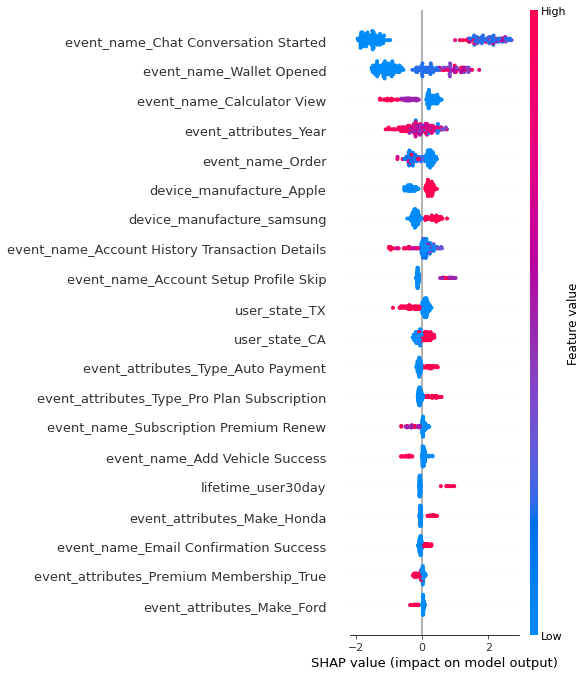

F1 score: 0.7412156695722038


In [96]:
shap.initjs()

num_trains = 5

random_states = range(num_trains)
shap_values = np.zeros(clean_df.shape[1]-1)

shap_values = 0
f1 = 0

params = {'objective': 'binary:logistic', 'eval_metric': 'logloss',
          'eta': 0.1,
          'subsample': 0.3,
          }

for random_state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(clean_df.drop(['event_name_Subscription Premium Cancel'], axis=1),
                                                        df_model['event_name_Subscription Premium Cancel'],
                                                        test_size=0.3, random_state=random_state)
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train, verbose=False)

    y_pred = model_xgb.predict(X_test)
    f1 += metrics.f1_score(y_test, y_pred)
    
    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(X_test)


# visualize the first prediction's explanation

f1 /= num_trains

shap.summary_plot(shap_values, X_test)

print(f'F1 score:', f1)

# cross-val на SHAP

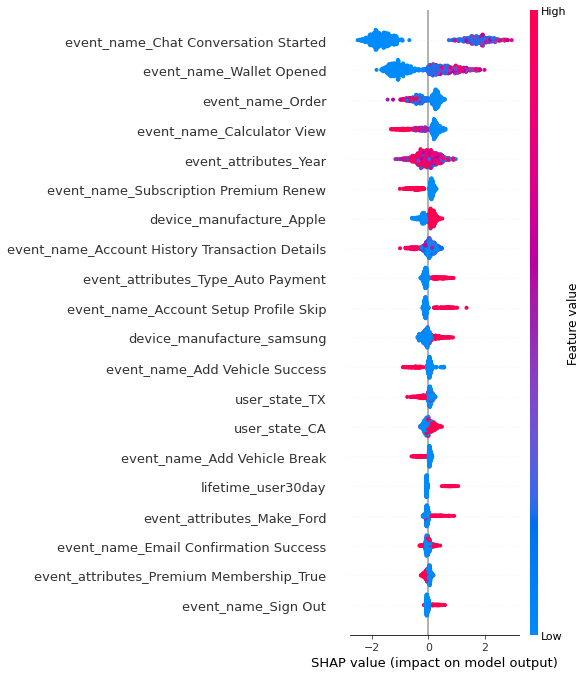

F1 score: 0.735909765055316


In [95]:
from catboost import CatBoostClassifier, Pool
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

shap.initjs()



params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.1,
          'subsample':0.3,
         }

model_xgb = XGBClassifier(**params)

SHAP_values_per_fold = []

f1 = 0


X = clean_df.drop(['event_name_Subscription Premium Cancel'],axis=1)
y = df_model['event_name_Subscription Premium Cancel']


#Establish CV scheme
CV = KFold(n_splits=5, shuffle=True, random_state=10)

ix_training, ix_test = [], []
# Loop through each fold and append the training & test indices to the empty lists above
for fold in CV.split(clean_df):
    ix_training.append(fold[0]), ix_test.append(fold[1])

for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):

    X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
    y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
    

    
    model_xgb.fit(X_train, y_train, verbose=False)
    
    y_pred = model_xgb.predict(X_test)

    f1 += metrics.f1_score(y_test, y_pred)

    
    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(X_test)
    

    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs) #-#-#
    
    
f1 /= len(ix_training)


new_index = [ix for ix_test_fold in ix_test for ix in ix_test_fold]


shap.summary_plot(np.array(SHAP_values_per_fold), X.reset_index(drop=True).reindex(new_index))

print(f'F1 score:', f1)